### Saha for N Ionization

The ionization energies are obtained from [NIST](https://physics.nist.gov/cgi-bin/ASD/ie.pl?spectra=Xe&units=1&at_num_out=on&el_name_out=on&seq_out=on&shells_out=on&level_out=on&e_out=0&unc_out=on&biblio=on)

The statistical weights are approximately derived also with NIST, using g_i = 2 J_i + 1 of the ground level of that state


In [1]:
from hnc.hnc.constants import *
from hnc.hnc.misc import More_TF_Zbar

import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from pandas import read_csv

from scipy.interpolate import interp1d

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14

color_smooth = lambda N: plt.cm.viridis(np.linspace(0,1,N))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


ModuleNotFoundError: No module named 'mendeleev'


In [6]:
def λD(T):
    return np.sqrt(2*π/(m_e*T))

def saha_equation(ne, T, Δε, degeneracy_ratio):
    # Saha equation in atomic units
    saha_ratio = degeneracy_ratio * 2*λD(T)**-3 * np.exp(- Δε / T) / ne
    test = saha_ratio
    return test#saha_ratio

def ΔU_SP(ionization_fractions, nn, Ti ): # Stwart-Pyat as written by Crowley assuming α=1, so Λ=Λ_tilde in https://arxiv.org/pdf/1309.1456
    Zj = np.arange(len(ionization_fractions))
    Zp = get_Zp(ionization_fractions)
    ne = get_ne(nn, ionization_fractions)
    rj = get_rj(Zj, ne)
    Γj_array = get_Γj(Zj, Zp, rj, Ti)
    Λ_array = get_Λ(Γj_array)
    return np.nan_to_num( - Ti/(2*Zp)*( (1 + Λ_array)**(2/3) - 1 ), nan=0)

def get_Λ(Γj): # NOT Λ_tilde
    Λ = (3*Γj)**(3/2)
    return Λ
    
def get_Zp(ionization_fractions):
    Zj = np.arange(len(ionization_fractions))
    return np.sum(ionization_fractions*Zj**2)/np.sum(ionization_fractions*Zj)

def get_rj(Zj, ne): #ion sphere radius
    return ( 3*Zj/(4*π*ne) )**(1/3)

def get_Γj(Zj, Zp, rj, Ti): # weird strong coupling parameter
    Γj = Zj*Zp/(rj*Ti)
    return Γj

def get_ne(nn, ionization_fractions):
    return nn*get_Zbar(ionization_fractions)

def get_Zbar(ionization_fractions):
    Zj = np.arange(len(ionization_fractions))
    return np.sum(ionization_fractions * Zj)

def get_ionization_fractions(ionization_fractions, nn, T, N, IPD = True):
    unnormalized_fractions = [1]
    ne = get_ne(nn, ionization_fractions)
    print(N, len(ionization_fractions))
    for i in range(N):
        degeneracy_ratio = degeneracies[i + 1] / degeneracies[i]
        if IPD==True:
            ipd_energies = ΔU_SP(ionization_fractions, nn, T )
        else:
            ipd_energies = np.zeros_like(ionization_fractions)
        new_ionization_energies = ionizationenergies_AU[:N+1] + ipd_energies
        ionizationenergy_difference = new_ionization_energies[i+1] - new_ionization_energies[i]
        ionization_ratio = saha_equation(ne, T, ionizationenergy_difference, degeneracy_ratio) # n_{i+1}/n_{i}
        unnormalized_fractions.append(ionization_ratio*unnormalized_fractions[-1])
    new_ionization_fractions = unnormalized_fractions/np.sum(unnormalized_fractions)
    return new_ionization_fractions, new_ionization_energies
    
def calculate_ionization_fractions(N_ions, nn, T, initial_guess = None, IPD = True):
    # Initial guess for ionization fractions (all neutral initially)
    N_atoms = N_ions + 1
    
    if initial_guess is None:
        More_Zbar = More_TF_Zbar(Z, nn_invcc*invcc_to_AU, T_K*K_to_AU)
        fake_ionization_fraction = np.zeros(N_atoms)
        fake_ionization_fraction[1] = More_Zbar
        initial_guess = get_ionization_fractions(fake_ionization_fraction, nn*More_Zbar, T, N_ions, IPD=False)[0].copy()
    
    fractions = np.array(initial_guess).copy()
    # Minimize the residuals to find the self-consistent ionization fractions
    
    α = 0.1
    iters = 0
    while iters < 1000:
        Zbar_old = get_Zbar(fractions)
        new_fractions, χs = get_ionization_fractions(fractions, nn, T, N_ions, IPD=IPD)
        fractions = α*new_fractions + (1-α)*fractions
        Zbar = get_Zbar(fractions)
        err = Zbar/Zbar_old-1
        # print(f"Zbar Old: {Zbar_old:0.3f}, New: {Zbar:0.3f}, rel change: {err:0.3e}")
        iters +=1
        # print("\tMinimizer success = ", result)
        # for i, fraction in enumerate(fractions):
        #     print(f"Ionization state {i}: {fraction:.2e}")
            
    # Calculate the average ionization
    average_ionization = get_Zbar(fractions)
    return average_ionization, fractions, χs



In [7]:
nn_invcc_at_Pbar_TK = lambda Pbar, TK: Pbar*bar_to_AU/(TK*K_to_AU)*AU_to_invcc

Xe_nn_invcc = nn_invcc_at_Pbar_TK(5, 290)
He_nn_invcc = nn_invcc_at_Pbar_TK(74, 290)
Ar_nn_invcc = nn_invcc_at_Pbar_TK(25, 290)

print(f"Xe ne = {Xe_nn_invcc:0.3e} [1/cc] ")
print(f"He ne = {He_nn_invcc:0.3e} [1/cc] ") 
print(f"Ar ne = {Ar_nn_invcc:0.3e} [1/cc] ")

Xe_TK_peak = 16.60952380952381e3 # 0 ns?
He_TK_peak = 14.790528233151186e3 # 0.0031746031746031746 ns
Ar_TK_peak = 17.761029411764707e3 # 0.008097165991902834 ns?

Xe ne = 1.249e+20 [1/cc] 
He ne = 1.848e+21 [1/cc] 
Ar ne = 6.244e+20 [1/cc] 


In [8]:
# https://physics.nist.gov/cgi-bin/ASD/ie.pl?spectra=Ar&units=1&at_num_out=on&el_name_out=on&seq_out=on&shells_out=on&level_out=on&e_out=0&unc_out=on&biblio=on
Xe_ionization_energies_eV = np.array([0, 12.1298437, 20.975, 31.05, 42.20 , 54.1, 66.703, 91.6, 105.9778, 179.84, 202.0, 229.02])
Xe_J_ground_level = np.array([0, 3/2, 2, 3/2, 0, 1/2, 0, 1/2, 0, 5/2, 4, 9/2])
Xe_ionization_degeneracies = 2*Xe_J_ground_level + 1

# https://physics.nist.gov/cgi-bin/ASD/ie.pl?spectra=Ar&units=1&at_num_out=on&el_name_out=on&seq_out=on&shells_out=on&level_out=on&e_out=0&unc_out=on&biblio=on
Ar_ionization_energies_eV = np.array([0, 15.7596119, 27.62967, 40.735, 59.58, 74.84, 91.290])
Ar_J_ground_level = np.array([0, 3/2, 2, 3/2, 0, 1/2, 0])
Ar_ionization_degeneracies = 2*Ar_J_ground_level + 1

# https://physics.nist.gov/cgi-bin/ASD/ie.pl?spectra=He&units=1&at_num_out=on&el_name_out=on&seq_out=on&shells_out=on&level_out=on&e_out=0&unc_out=on&biblio=on
He_ionization_energies_eV = np.array([0, 24.587389011, 54.4177655282])
He_J_ground_level = np.array([0, 1/2, 0 ])
He_ionization_degeneracies = 2*He_J_ground_level + 1


### Single Test

In [10]:
# Input: Number of ionizations
Z = 54
N_ions = 2  # Number of ions, so N_ions + 1 = number of nuclear types
nn_invcc = Xe_nn_invcc  # 1/cc
T_K = 16.5e3 # Kelvin

# Ionization energies for Xenon (in atomic units)
ionizationenergies_eV = Xe_ionization_energies_eV # up to sixth ionization
ionizationenergies_AU = ionizationenergies_eV * eV_to_AU

# Degeneracy numbers for Xenon ionization states
degeneracies = Xe_ionization_degeneracies
print("g_i statistical weights are: ", degeneracies)

nn_AU = nn_invcc * invcc_to_AU
T_AU = T_K * K_to_AU

# Calculate ionization fractions
iters = np.array([0])
verbose = True
av_ionization, ionization_fractions, χ_energies = calculate_ionization_fractions(N_ions, nn_AU, T_AU, IPD=False)

# Print the results
for i, fraction in enumerate(ionization_fractions):
    print(f"Ionization state {i}: {fraction:.2e}")
print(f"Average ionization Zbar = {av_ionization:.3e}")
get_Zp(ionization_fractions), ionization_fractions

g_i statistical weights are:  [ 1.  4.  5.  4.  1.  2.  1.  2.  1.  6.  9. 10.]
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3
2 3


(1.5515711326031183, array([0.76019953, 0.14848289, 0.09131758]))

### Xenon

In [11]:
Z = 54
nn_invcc = Xe_nn_invcc  # 1/cc

# Ionization energies for Xenon (in atomic units)
ionizationenergies_eV = Xe_ionization_energies_eV  # NIST
ionizationenergies_AU = ionizationenergies_eV * eV_to_AU

# Degeneracy numbers for Xenon ionization states
degeneracies = Xe_ionization_degeneracies  # Considering Hund's rule. Not counting any states with anti-parallel spins.

def get_saha_over_TK(T_K_array, N_ions, verbose=False, IPD=True):
    ionization_fraction_lists = []
    av_ionizations_list = []
    χ_list = []

    for T_K in T_K_array:
        T_AU = T_K*K_to_AU
        verbose = False
        av_ionization, ionization_fractions, χ_energies = calculate_ionization_fractions(N_ions, nn_AU, T_AU, IPD=IPD)
        if verbose:
            print(f"\t", [f"{frac:0.3e}".format(frac) for frac in ionization_fractions])
        av_ionizations_list.append(av_ionization)
        ionization_fraction_lists.append(ionization_fractions)
        χ_list.append(χ_energies)
        if verbose:
            print(f"\tSaha Zbar = {av_ionization:0.3e}")
    
    return np.array(av_ionizations_list), np.array(ionization_fraction_lists), np.array(χ_list)

T_K_array = np.geomspace(1e2, 1e5, num=100)

Zbar_N1_ipd_list, xi_N1_ipd_list, χ_N1_ipd_list = get_saha_over_TK(T_K_array, 1, IPD=True)
Zbar_N1_noipd_list, xi_N1_noipd_list, χ_N1_noipd_list = get_saha_over_TK(T_K_array, 1, IPD=False)

Zbar_NN_ipd_list, xi_NN_ipd_list, χ_NN_ipd_list = get_saha_over_TK(T_K_array, 5, IPD=True)
Zbar_NN_noipd_list, xi_NN_noipd_list, χ_NN_noipd_list = get_saha_over_TK(T_K_array, 5, IPD=False)

/tmp/ipykernel_41975/4199048424.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(ionization_fractions*Zj**2)/np.sum(ionization_fractions*Zj)
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: divide by zero encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: invalid value encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:6: RuntimeWarning: invalid value encountered in scalar divide
  saha_ratio = degeneracy_ratio * 2*λD(T)**-3 * np.exp(- Δε / T) / ne
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: overflow encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:31: RuntimeWarning: invalid value encountered in divide
  Γj = Zj*Zp/(rj*Ti)
/tmp/ipykernel_41975/4199048424.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  saha_ratio = degeneracy_ratio * 2*λD(T)**-3 * np.exp(- Δε / T) / ne


In [12]:
ofaa_data = read_csv("Xenon_5bar_OFAA.dat", delim_whitespace=True, header=0)
ofaa_min_valid_index = 3
ofaa_data[ofaa_min_valid_index:]

,T[K],Zbar
3,4641.589,0.040702
4,7742.637,0.205314
5,12915.500,0.483591
6,21544.350,0.901763
7,35938.140,1.514539
8,59948.430,2.404611
9,100000.000,3.686170


/tmp/ipykernel_41975/4199048424.py:31: RuntimeWarning: invalid value encountered in divide
  Γj = Zj*Zp/(rj*Ti)


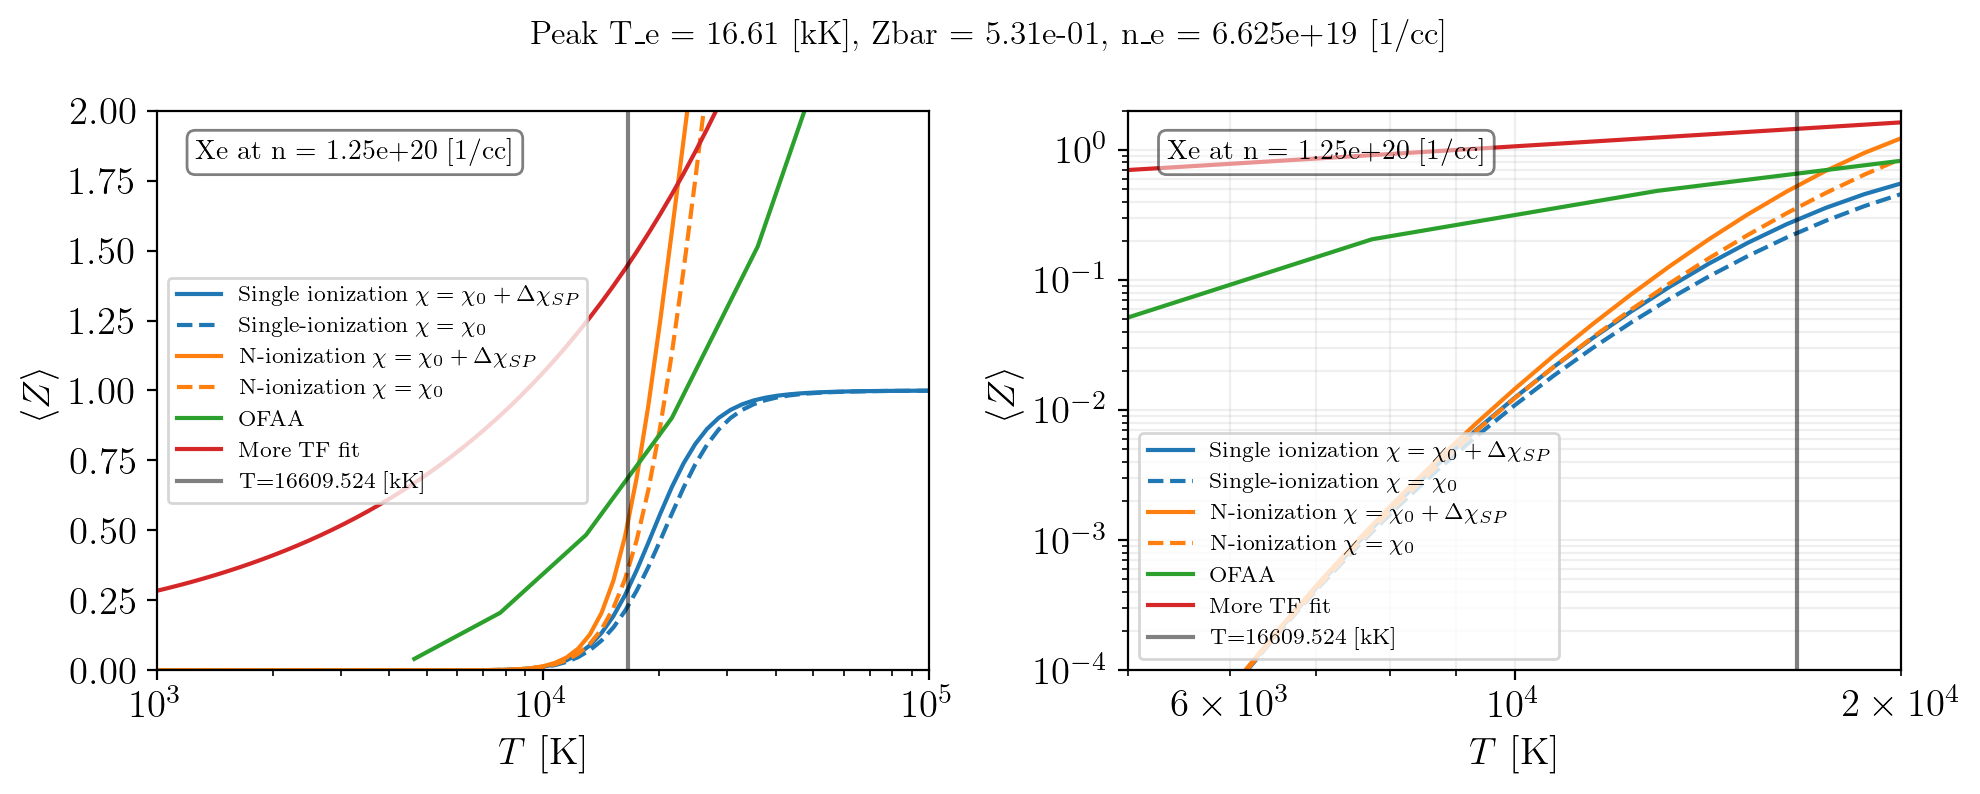

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=10

linestyle = '-'
for ax in axs:
    ax.plot(T_K_array, Zbar_N1_ipd_list, color=color_cycle[0], linestyle=linestyle, label=r"Single ionization $\chi = \chi_0 + \Delta \chi_{SP}$ ")
    ax.plot(T_K_array, Zbar_N1_noipd_list, color=color_cycle[0], linestyle='--', label=r"Single-ionization $\chi = \chi_0$ ")
    ax.plot(T_K_array, Zbar_NN_ipd_list, color=color_cycle[1], linestyle=linestyle, label=r"N-ionization $\chi = \chi_0 + \Delta \chi_{SP}$ ")
    ax.plot(T_K_array, Zbar_NN_noipd_list, color=color_cycle[1], linestyle='--', label=r"N-ionization $\chi = \chi_0$ ")

    ax.plot(ofaa_data['T[K]'][ofaa_min_valid_index:], ofaa_data['Zbar'][ofaa_min_valid_index:], color=color_cycle[2], linestyle=linestyle, label="OFAA")

    ax.plot(T_K_array, More_TF_Zbar(Z, nn_invcc*invcc_to_AU, T_K_array*K_to_AU),linestyle=linestyle, color=color_cycle[3], label="More TF fit")
    
    ax.set_xscale('log')

    ax.set_ylabel(r"$\langle Z \rangle$")
    ax.set_xlabel(r"$T$ [K]")

    # text
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"Xe at n = {nn_invcc:0.2e} [1/cc]"
    ax.text(0.05, 0.95, inset_text, transform=ax.transAxes,
            verticalalignment='top', bbox=props)

    ax.axvline(Xe_TK_peak,linestyle='-', color='k', label=f'T={Xe_TK_peak:0.3f} [kK]', alpha=0.5)
    plt.grid(visible=None, which='both', axis='both', alpha=0.2)

Xe_peak_Zbar = get_saha_over_TK(np.array([Xe_TK_peak]), 5, IPD=True)[0][0]

fig.suptitle(f"Peak T_e = {Xe_TK_peak/1e3:0.2f} [kK], Zbar = {Xe_peak_Zbar:0.2e}, n_e = {Xe_peak_Zbar*Xe_nn_invcc:0.3e} [1/cc]")

ax=axs[0]
ax.set_xlim(1e3, 1e5)
ax.set_ylim(0,2)
ax.legend(loc='center left', fontsize=8)

ax=axs[1]
ax.set_xlim(5e3, 2e4)
ax.set_ylim(1e-4,2)
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=8)


plt.tight_layout()

### Helium

In [14]:
Z, A = 2, 4
nn_invcc = He_nn_invcc # 1/cc

# Ionization energies for Xenon (in atomic units)
ionizationenergies_eV = He_ionization_energies_eV  # NIST
ionizationenergies_AU = ionizationenergies_eV * eV_to_AU

# Degeneracy numbers for Xenon ionization states
degeneracies = He_ionization_degeneracies  # Considering Hund's rule. Not counting any states with anti-parallel spins.


def get_saha_over_TK(T_K_array, N_ions, verbose=False, IPD=True):
    ionization_fraction_lists = []
    av_ionizations_list = []
    χ_list = []

    for T_K in T_K_array:
        T_AU = T_K*K_to_AU
        if verbose:
            print(f"More initial Zbar guess: {More_Zbar:0.3e}")
        verbose = False
        av_ionization, ionization_fractions, χ_energies = calculate_ionization_fractions(N_ions, nn_AU, T_AU,IPD=IPD)
        if verbose:
            print(f"\t", [f"{frac:0.3e}".format(frac) for frac in ionization_fractions])
        av_ionizations_list.append(av_ionization)
        ionization_fraction_lists.append(ionization_fractions)
        χ_list.append(χ_energies)
        if verbose:
            print(f"\tSaha Zbar = {av_ionization:0.3e}")
    
    return np.array(av_ionizations_list), np.array(ionization_fraction_lists), np.array(χ_list)

T_K_array = np.geomspace(1e2, 1e5, num=100)

Zbar_N1_ipd_list, xi_N1_ipd_list, χ_N1_ipd_list = get_saha_over_TK(T_K_array, 1, IPD=True)
Zbar_N1_noipd_list, xi_N1_noipd_list, χ_N1_noipd_list = get_saha_over_TK(T_K_array, 1, IPD=False)

Zbar_NN_ipd_list, xi_NN_ipd_list, χ_NN_ipd_list = get_saha_over_TK(T_K_array, 2, IPD=True)
Zbar_NN_noipd_list, xi_NN_noipd_list, χ_NN_noipd_list = get_saha_over_TK(T_K_array, 2, IPD=False)

/tmp/ipykernel_41975/4199048424.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(ionization_fractions*Zj**2)/np.sum(ionization_fractions*Zj)
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: divide by zero encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: invalid value encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:6: RuntimeWarning: invalid value encountered in scalar divide
  saha_ratio = degeneracy_ratio * 2*λD(T)**-3 * np.exp(- Δε / T) / ne
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: overflow encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:31: RuntimeWarning: invalid value encountered in divide
  Γj = Zj*Zp/(rj*Ti)


/tmp/ipykernel_41975/4199048424.py:31: RuntimeWarning: invalid value encountered in divide
  Γj = Zj*Zp/(rj*Ti)


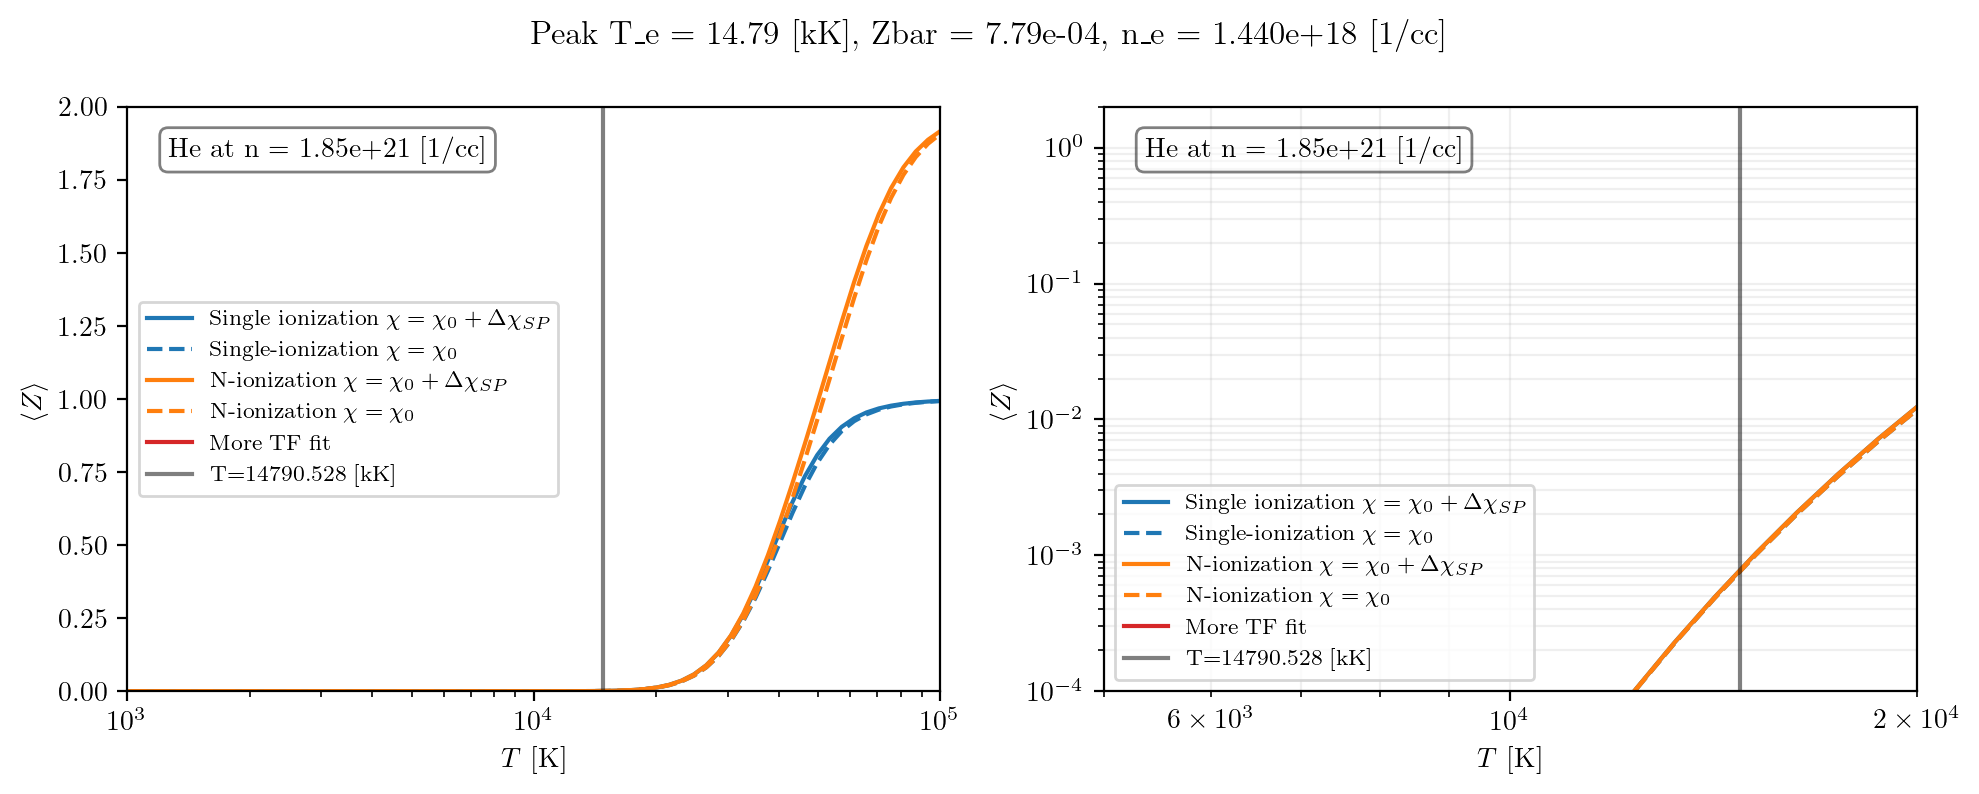

In [16]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=10

linestyle = '-'
for ax in axs:
    ax.plot(T_K_array, Zbar_N1_ipd_list, color=color_cycle[0], linestyle=linestyle, label=r"Single ionization $\chi = \chi_0 + \Delta \chi_{SP}$ ")
    ax.plot(T_K_array, Zbar_N1_noipd_list, color=color_cycle[0], linestyle='--', label=r"Single-ionization $\chi = \chi_0$ ")
    ax.plot(T_K_array, Zbar_NN_ipd_list, color=color_cycle[1], linestyle=linestyle, label=r"N-ionization $\chi = \chi_0 + \Delta \chi_{SP}$ ")
    ax.plot(T_K_array, Zbar_NN_noipd_list, color=color_cycle[1], linestyle='--', label=r"N-ionization $\chi = \chi_0$ ")

    ax.plot(More_TF_Zbar(Z, nn_invcc*invcc_to_AU, T_K_array*K_to_AU),linestyle=linestyle, color=color_cycle[3], label="More TF fit")
    
    
    ax.set_xscale('log')

    ax.set_ylabel(r"$\langle Z \rangle$")
    ax.set_xlabel(r"$T$ [K]")

    # text
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"He at n = {nn_invcc:0.2e} [1/cc]"
    ax.text(0.05, 0.95, inset_text, transform=ax.transAxes,
            verticalalignment='top', bbox=props)

    ax.axvline(He_TK_peak,linestyle='-', color='k', label=f'T={He_TK_peak:0.3f} [kK]', alpha=0.5)
    plt.grid(visible=None, which='both', axis='both', alpha=0.2)

He_peak_Zbar = get_saha_over_TK(np.array([He_TK_peak]), 2, IPD=True)[0][0]
fig.suptitle(f"Peak T_e = {He_TK_peak/1e3:0.2f} [kK], Zbar = {He_peak_Zbar:0.2e}, n_e = {He_peak_Zbar*He_nn_invcc:0.3e} [1/cc]")

ax=axs[0]
ax.set_xlim(1e3, 1e5)
ax.set_ylim(0,2)
ax.legend(loc='center left', fontsize=8)

ax=axs[1]
ax.set_xlim(5e3, 2e4)
ax.set_ylim(1e-4,2)
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=8)


plt.tight_layout()

### Argon

In [17]:
Z, A = 18, 39.948
nn_invcc = Ar_nn_invcc # 1/cc

# Ionization energies for Xenon (in atomic units)
ionizationenergies_eV = Ar_ionization_energies_eV # NIST
ionizationenergies_AU = ionizationenergies_eV * eV_to_AU

# Degeneracy numbers for Xenon ionization states
degeneracies = Ar_ionization_degeneracies  # Considering Hund's rule. Not counting any states with anti-parallel spins.


def get_saha_over_TK(T_K_array, N_ions, verbose=False, IPD=True):
    ionization_fraction_lists = []
    av_ionizations_list = []
    χ_list = []

    for T_K in T_K_array:
        T_AU = T_K*K_to_AU
        if verbose:
            print(f"More initial Zbar guess: {More_Zbar:0.3e}")
        verbose = False
        av_ionization, ionization_fractions, χ_energies = calculate_ionization_fractions(N_ions, nn_AU, T_AU,IPD=IPD)
        if verbose:
            print(f"\t", [f"{frac:0.3e}".format(frac) for frac in ionization_fractions])
        av_ionizations_list.append(av_ionization)
        ionization_fraction_lists.append(ionization_fractions)
        χ_list.append(χ_energies)
        if verbose:
            print(f"\tSaha Zbar = {av_ionization:0.3e}")
    
    return np.array(av_ionizations_list), np.array(ionization_fraction_lists), np.array(χ_list)

T_K_array = np.geomspace(1e2, 1e5, num=100)

Zbar_N1_ipd_list, xi_N1_ipd_list, χ_N1_ipd_list = get_saha_over_TK(T_K_array, 1, IPD=True)
Zbar_N1_noipd_list, xi_N1_noipd_list, χ_N1_noipd_list = get_saha_over_TK(T_K_array, 1, IPD=False)

Zbar_NN_ipd_list, xi_NN_ipd_list, χ_NN_ipd_list = get_saha_over_TK(T_K_array, 5, IPD=True)
Zbar_NN_noipd_list, xi_NN_noipd_list, χ_NN_noipd_list = get_saha_over_TK(T_K_array, 5, IPD=False)

/tmp/ipykernel_41975/4199048424.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(ionization_fractions*Zj**2)/np.sum(ionization_fractions*Zj)
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: divide by zero encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:28: RuntimeWarning: invalid value encountered in divide
  return ( 3*Zj/(4*π*ne) )**(1/3)
/tmp/ipykernel_41975/4199048424.py:6: RuntimeWarning: invalid value encountered in scalar divide
  saha_ratio = degeneracy_ratio * 2*λD(T)**-3 * np.exp(- Δε / T) / ne
/tmp/ipykernel_41975/4199048424.py:31: RuntimeWarning: invalid value encountered in divide
  Γj = Zj*Zp/(rj*Ti)
/tmp/ipykernel_41975/4199048424.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  saha_ratio = degeneracy_ratio * 2*λD(T)**-3 * np.exp(- Δε / T) / ne


/tmp/ipykernel_41975/4199048424.py:31: RuntimeWarning: invalid value encountered in divide
  Γj = Zj*Zp/(rj*Ti)


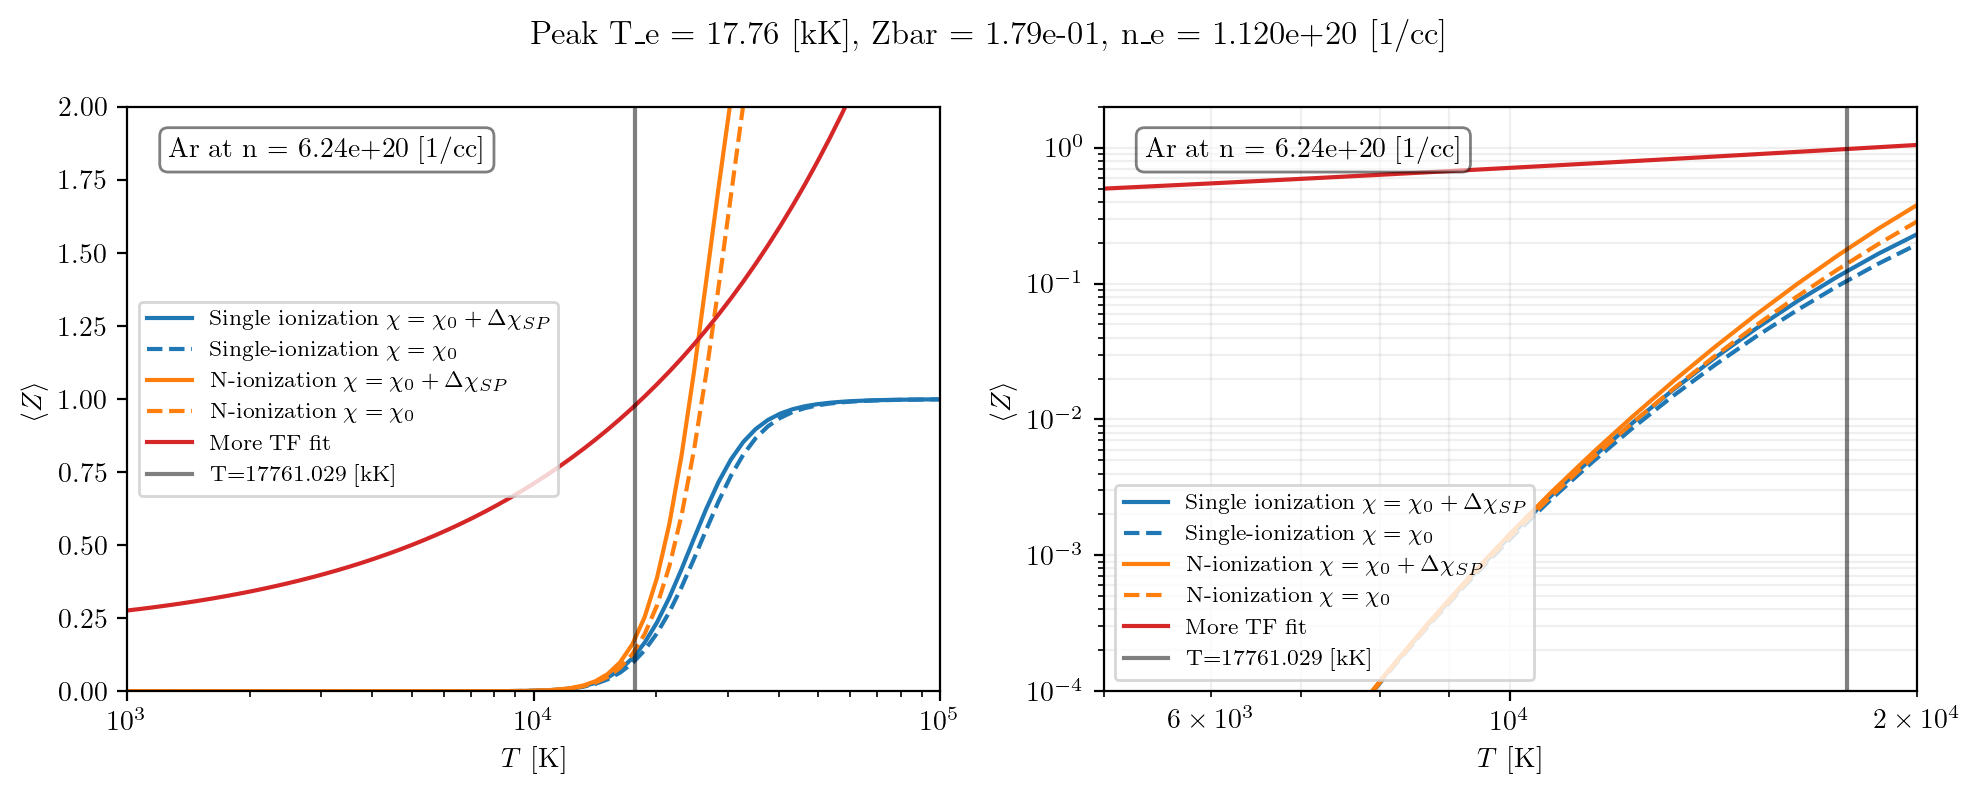

In [18]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=10

linestyle = '-'
for ax in axs:
    ax.plot(T_K_array, Zbar_N1_ipd_list, color=color_cycle[0], linestyle=linestyle, label=r"Single ionization $\chi = \chi_0 + \Delta \chi_{SP}$ ")
    ax.plot(T_K_array, Zbar_N1_noipd_list, color=color_cycle[0], linestyle='--', label=r"Single-ionization $\chi = \chi_0$ ")
    ax.plot(T_K_array, Zbar_NN_ipd_list, color=color_cycle[1], linestyle=linestyle, label=r"N-ionization $\chi = \chi_0 + \Delta \chi_{SP}$ ")
    ax.plot(T_K_array, Zbar_NN_noipd_list, color=color_cycle[1], linestyle='--', label=r"N-ionization $\chi = \chi_0$ ")

    ax.plot(T_K_array, More_TF_Zbar(Z, nn_invcc*invcc_to_AU, T_K_array*K_to_AU),linestyle=linestyle, color=color_cycle[3], label="More TF fit")
    ax.set_xscale('log')

    ax.set_ylabel(r"$\langle Z \rangle$")
    ax.set_xlabel(r"$T$ [K]")

    # text
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"Ar at n = {nn_invcc:0.2e} [1/cc]"
    ax.text(0.05, 0.95, inset_text, transform=ax.transAxes,
            verticalalignment='top', bbox=props)

    ax.axvline(Ar_TK_peak,linestyle='-', color='k', label=f'T={Ar_TK_peak:0.3f} [kK]', alpha=0.5)
    plt.grid(visible=None, which='both', axis='both', alpha=0.2)

Ar_peak_Zbar = get_saha_over_TK(np.array([Ar_TK_peak]), 5, IPD=True)[0][0]
fig.suptitle(f"Peak T_e = {Ar_TK_peak/1e3:0.2f} [kK], Zbar = {Ar_peak_Zbar:0.2e}, n_e = {Ar_peak_Zbar*Ar_nn_invcc:0.3e} [1/cc]")

ax=axs[0]
ax.set_xlim(1e3, 1e5)
ax.set_ylim(0,2)
ax.legend(loc='center left', fontsize=8)

ax=axs[1]
ax.set_xlim(5e3, 2e4)
ax.set_ylim(1e-4,2)
ax.set_yscale('log')
ax.legend(loc='lower left', fontsize=8)


plt.tight_layout()